In [1]:
#Note: this notebook is like graph1, but it will specifically process particular tokens in the loss_per_token_scored.csv file

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
sns.set()
# sns.set_context('paper', font_scale=0.73)
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
!echo $CONDA_DEFAULT_ENV

In [3]:
#paths
root_dir = "/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_raretoken"
group_folder = "run"
exp_name= ["pile1e8_20len"]
seed_name = ["seed0", "seed1", "seed2", "seed3", "seed4"]
model_sizes = ["70M"]
scored_file = "loss_per_token_scored.csv"

#these are the tokens that we will be averaging the losses to get our statistic
start_attend = 0
end_attend = 100

experiments = [f"{root_dir}/{group_folder}/{exp}_{seed}/{model_size}" for model_size in model_sizes for exp in exp_name for seed in seed_name]
experiments

['/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_raretoken/run/pile1e8_20len_seed0/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_raretoken/run/pile1e8_20len_seed1/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_raretoken/run/pile1e8_20len_seed2/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_raretoken/run/pile1e8_20len_seed3/70M',
 '/mnt/nfs1/ryan/haveibeentrainedon/models/unstealthy_raretoken/run/pile1e8_20len_seed4/70M']

In [4]:
models = list(filter(lambda x: x[-5:] == "model", os.listdir(experiments[0])))
models = sorted(models, key = lambda x: eval(x[:-6]))
models

['0_model',
 '10000_model',
 '20000_model',
 '30000_model',
 '40000_model',
 '50000_model']

In [5]:
def read_file(file_name):
    data = []
    with open(file_name, 'r') as file:
        for line in file:
            row = [eval(element.strip()) for element in line.split(",")]
            data.append(row[start_attend:end_attend])
    return data

In [6]:
experiments_dfs = []
for experiment in experiments:
    model_dfs = []
    for model_type in models:
        model_dfs += [read_file(os.path.join(experiment,  model_type, scored_file))]
    experiments_dfs.append(model_dfs)
print(len(experiments_dfs))
print(len(model_dfs))

5
6


In [7]:

y_axises = []
null_means = []
null_stdev = []
statistic_total = []
for experiment_dfs in experiments_dfs:
    y_axis = []
    null_raw = []
    null_std = []
    statistic_temp = []
    for model_df in experiment_dfs:
        null_raw = model_df[1:]
        #we first average over tokens to get average loss per each example
        null = [statistics.mean(row) for row in null_raw]

        #we then calculate the average and stdev of this null distribution
        mean = statistics.mean(null)
        stdev = statistics.stdev(null)

        statistic = statistics.mean(model_df[0])
        # print(f"statistic = {statistic}, mean = {mean}, stdev = {stdev}")

        statistic_temp += [statistic]

        y_axis += [(statistic - mean) / stdev]
        null_means += [mean]
        null_std += [stdev]
    y_axises.append(y_axis)
    statistic_total.append(statistic_temp)
    null_stdev.append(null_std)

In [8]:
#reshape all the results into (length, seed, repetitions) format
def reshape_input(arr):
    arr = np.array(arr)
    arr = arr.reshape(len(exp_name), len(seed_name), -1)
    return arr

new_y_axises = reshape_input(y_axises)
new_null_means = reshape_input(null_means)
new_null_stdev = reshape_input(null_stdev)
new_statistic_total = reshape_input(statistic_total)

In [9]:
seaborn_table = []
convert_arr = [0, 10000, 20000, 30000, 40000, 50000]
for j in range(len(new_y_axises[0])):
    for k in range(len(new_y_axises[0][j])):
        seaborn_table.append([new_y_axises[0][j][k], convert_arr[k]])



In [10]:
df = pd.DataFrame(seaborn_table, columns=["Z-Score", "Rank"])
df

,Z-Score,Rank
0,-8.996228,0
1,-8.777645,10000
2,-9.272463,20000
3,-10.221267,30000
4,-9.699465,40000
5,-10.167800,50000
6,-7.655060,0
7,-9.430427,10000
8,-9.572431,20000
9,-9.461610,30000


<Axes: xlabel='Rank', ylabel='Z-Score'>

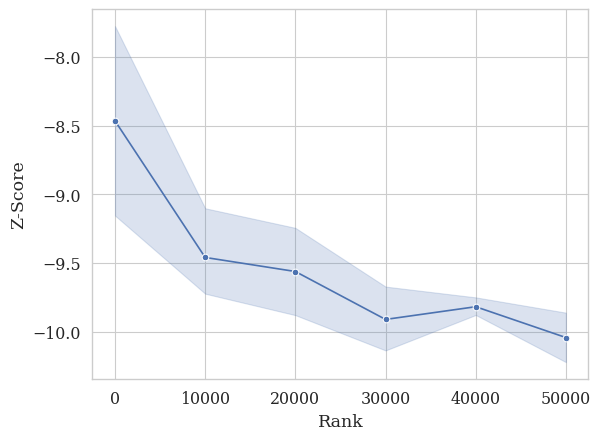

In [11]:
sns.lineplot(data=df, x="Rank", y="Z-Score", errorbar=("ci", 95), marker='o')

In [12]:
df.to_csv('/home/ryan/haveibeentrainedon/unstealthy/unstealthy_raretoken/raretoken_graph_data.csv', index=False)

In [10]:
plot_values = new_y_axises.mean(axis=1)
plot_values[0]

array([ -8.46512202,  -9.45882032,  -9.5611424 ,  -9.90980803,
        -9.81734785, -10.04161318])

In [11]:
x_axis = [0,10000,20000,30000,40000,50000]
print(x_axis)

[0, 10000, 20000, 30000, 40000, 50000]


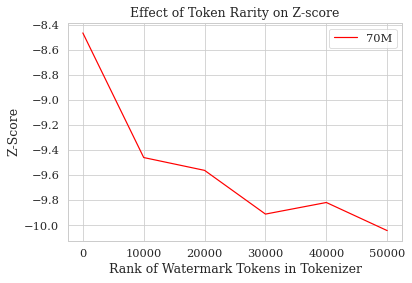

In [12]:
# Create a line plot for each set of y-values
sns.lineplot(x=x_axis, y=plot_values[0], color='red', label="70M")


# Customize the plot
plt.title('Effect of Token Rarity on Z-score')
plt.xlabel('Rank of Watermark Tokens in Tokenizer')
plt.ylabel('Z-Score')
plt.legend()

# Show the plot
plt.show()

In [13]:
null_mean_values = new_null_means.mean(axis=1)
null_stdev_values = new_null_stdev.mean(axis=1)
statistic_values = new_statistic_total.mean(axis=1)


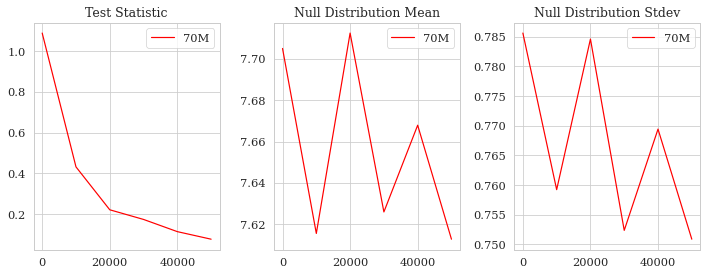

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
sns.lineplot(x=x_axis, y=statistic_values[0], color='red', label="70M")
plt.title('Test Statistic')

plt.subplot(1, 3, 2)  # 1 row, 2 columns, 1st subplot
sns.lineplot(x=x_axis, y=null_mean_values[0], color='red', label="70M")
plt.title('Null Distribution Mean')

# Creating the second plot (Bar plot)
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.lineplot(x=x_axis, y=null_stdev_values[0], color='red', label="70M")
plt.title('Null Distribution Stdev')

plt.tight_layout()
plt.show()

In [40]:
(statistic_values[0] - null_mean_values[0]) / null_stdev_values[0]

array([-8.42567053, -9.38189804, -9.41934314, -9.89309156, -9.80177847,
       -9.95025618])